In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [13]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [14]:
train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace=True)
test['Item_Weight'].fillna((test['Item_Weight'].mean()), inplace=True)

train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat'])
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['reg'], ['Regular'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], ['Regular'])

train['Outlet_Establishment_Year'] = 2013 - train['Outlet_Establishment_Year']
test['Outlet_Establishment_Year'] = 2013 - test['Outlet_Establishment_Year']

train['Outlet_Size'].fillna('Small',inplace=True)
test['Outlet_Size'].fillna('Small',inplace=True)

col = ['Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Fat_Content']
test['Item_Outlet_Sales'] = 0
combi = pd.concat([train, test], ignore_index=True)
number = LabelEncoder()
for i in col:
    combi[i] = number.fit_transform(combi[i].astype('str'))
    combi[i] = combi[i].astype('int')
train = combi[:train.shape[0]]
test = combi[train.shape[0]:]
test.drop('Item_Outlet_Sales',axis=1,inplace=True)

training = train.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
testing = test.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
y_train = training['Item_Outlet_Sales']
training.drop('Item_Outlet_Sales',axis=1,inplace=True)

features = training.columns
target = 'Item_Outlet_Sales'

X_train, X_test = training, testing

<ipython-input-14-2227e9884c10>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace=True)
<ipython-input-14-2227e9884c10>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

# Model exploration

In [15]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [16]:
model_factory = [
    RandomForestRegressor(),
    XGBRegressor(nthread=1),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(),
    ElasticNet(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()
]

for model in model_factory:
    model.seed = 42
    num_folds = 3

    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error')
    score_description = " %0.2f (+/- %0.2f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-5 RMSE: {score}'.format(
        model=model.__class__.__name__,
        score=score_description
    ))

RandomForestRegressor     CV-5 RMSE:  1149.57 (+/- 25488.40)
XGBRegressor              CV-5 RMSE:  1194.03 (+/- 9844.93)
Ridge                     CV-5 RMSE:  1206.41 (+/- 54020.12)
BayesianRidge             CV-5 RMSE:  1206.56 (+/- 52695.34)
ExtraTreesRegressor       CV-5 RMSE:  1194.49 (+/- 11280.09)
ElasticNet                CV-5 RMSE:  1259.18 (+/- 89803.16)
KNeighborsRegressor       CV-5 RMSE:  1245.71 (+/- 37275.84)
GradientBoostingRegressor CV-5 RMSE:  1086.12 (+/- 19711.92)


In [17]:
model = XGBRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_test)

sub = pd.DataFrame(data = pred, columns=['Item_Outlet_Sales'])
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']

cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)

array([-1422865.06314891, -1432622.18419024, -1421608.73318773])

In [18]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''

    def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
                       from the unlabled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'

        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed

        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target

    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
        )

        return self


    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)


        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])


        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels



        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)

    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)

    def get_model_name(self):
        return self.model.__class__.__name__

# Pseudo Labeler

In [19]:
model = PseudoLabeler(
    XGBRegressor(nthread=1),
    test,
    features,
    target,
    sample_rate = 0.3
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)

array([-1388912.77126161, -1358668.63542162, -1392835.61263166])

In [20]:
sub = pd.DataFrame(data = pred, columns=['Item_Outlet_Sales'])
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
sub.to_csv('pseudo-labelling.csv', index='False')

# Comparing xgboost with xgb with pseudo labelling

In [21]:
model_factory = [
    XGBRegressor(nthread=1),

    PseudoLabeler(
        XGBRegressor(nthread=1),
        test,
        features,
        target,
        sample_rate=0.3
    ),
]

for model in model_factory:
    model.seed = 42
    num_folds = 8

    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
    score_description = "MSE: %0.4f (+/- %0.4f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-{num_folds} {score_cv}'.format(
        model=model.__class__.__name__,
        num_folds=num_folds,
        score_cv=score_description
    ))

XGBRegressor              CV-8 MSE: 1183.6297 (+/- 156156.5398)
PseudoLabeler             CV-8 MSE: 1158.2413 (+/- 140451.7107)


# Performance of pseudo-labelling depedendance on sampling rate

In [22]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
    return PseudoLabeler(model, test, features, target)

model_factory = [
    RandomForestRegressor(n_jobs=1),
    XGBRegressor(),
]


model_factory = map(pseudo_label_wrapper, model_factory)


results = {}
num_folds = 5

for model in model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)

    results[model_name] = list()
    for sample_rate in sample_rates:
        model.sample_rate = sample_rate

        scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
        results[model_name].append(np.sqrt(scores.mean()*-1))

RandomForestRegressor
XGBRegressor


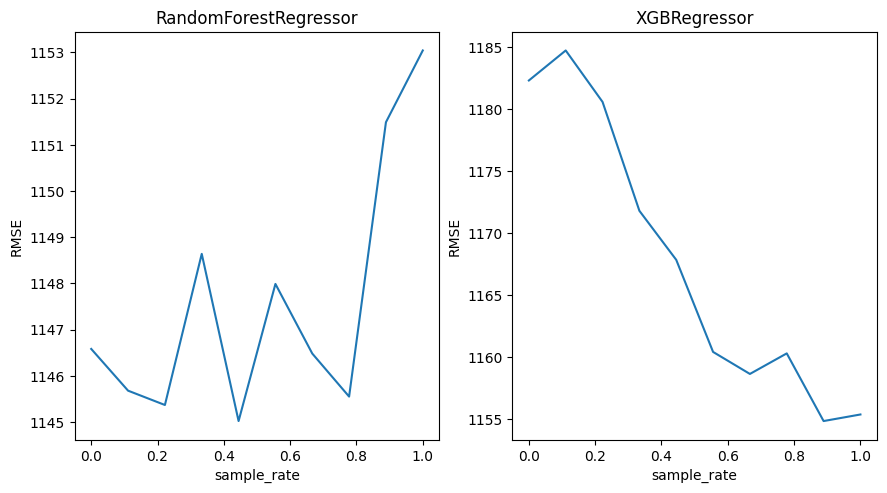

In [23]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items():
    plt.subplot(3, 3, i)
    i += 1

    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('RMSE')


plt.show()